In [3]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven

In [4]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


### Ny kode

In [5]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [6]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)

    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [53]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [54]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [55]:
energi_Wh = energi / 3600
energi_Wh

4.836338779081917

In [ ]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 91):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[6.450902817909735,
 6.523703115269509,
 6.5950387065194676,
 6.664853563752341,
 6.7331073816105524,
 6.7997291553008035,
 6.864673899370011,
 6.927898922904365,
 6.989362346371732,
 7.049023134639224,
 7.106841129726322,
 7.1627975100553,
 7.216861762902138,
 7.268977722334781,
 7.319136088298922,
 7.367283894657158,
 7.413448024042958,
 7.45755758107652,
 7.499598591426438,
 7.539564275507645,
 7.5774265353196135,
 7.613148654715336,
 7.646757990615015,
 7.678195515574488,
 7.707450770458183,
 7.734540257389362,
 7.759407642232443,
 7.782084178646079,
 7.80251347314164,
 7.820730501513349,
 7.836684248072414,
 7.850405477165848,
 7.8618484733071865,
 7.871043125788789,
 7.877949023865318,
 7.882597539053918,
 7.884947509205834,
 7.885031390119022,
 7.882812067475333,
 7.878321339060155,
 7.871526065940103,
 7.862457377919992,
 7.851089763590455,
 7.8374499090601555,
 7.821527795528299,
 7.803325861166109,
 7.782861175370817,
 7.760114323350914,
 7.735114018726117,
 7.707845057991673

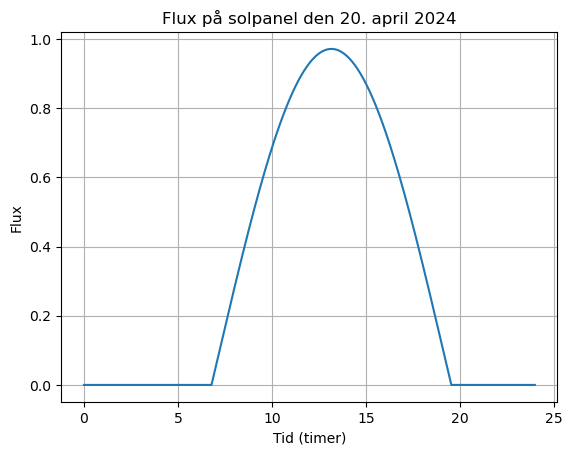

In [65]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

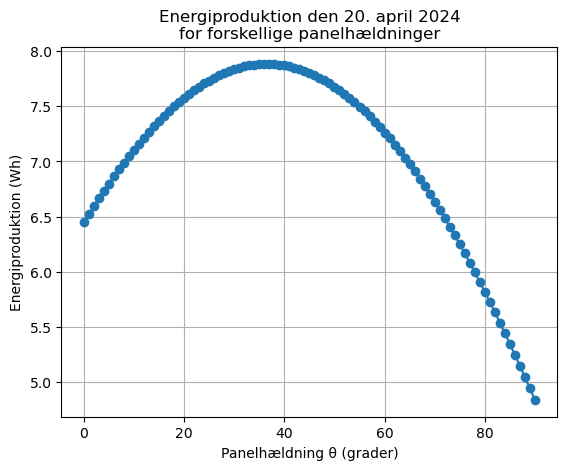

In [15]:
hældninger = np.arange(0, 91)  # 0° til 90°
plt.plot(hældninger, wh_energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()